In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
def resorte(u,t,w,l0):
    #l es la longitud del resorte en un t
    l=np.sqrt((u[4]-u[0])**2+(u[6]-u[2])**2)
    deriv = np.array([u[1],(w**2)*(l-l0)*(u[4]-u[0])/l,u[3],(w**2)*(l-l0)*(u[6]-u[2])/l,u[5],-(w**2)*(l-l0)*(u[4]-u[0])/l,u[7],-(w**2)*(l-l0)*(u[6]-u[2])/l])
    return deriv

In [4]:
#método de solución de la ODE: Runge-Kutta de cuarto orden
def runge_kutta_4to(f_user, u0, t, *args):

    n = t.size
    neq = u0.size
    u = np.zeros((n, neq))

    u[0] = u0
    
    dt = t[1]-t[0]
    
    for i in range(n-1):
        k1 = f_user(u[i], t[i],*args)
        k2 = f_user(u[i]+(1/2)*k1*dt, t[i+1]+ (1/2)*dt,*args )
        k3 = f_user(u[i]+(1/2)*k2*dt, t[i+1]+ (1/2)*dt,*args )
        k4 = f_user(u[i]+ k3*dt, t[i+1]+ dt,*args)
        u[i+1] = u[i] + (1/6)*dt*(k1+2*k2+2*k3+k4)
    return u

In [5]:
#Método de solución de la ODE: Bulrisch Stoer Modifciado

#Primero definimos la función que nos calcula el resultado final a un dt anterior del fin del intervalo.

def MedioModificado(f_user, U0, t, *args):
    # aquí el método de punto medio nos da el resultado final a un dt anterior del fin
    # del intervalo. Similar a los otros métodos estudiados
    n = t.size
    neq = U0.size
    u = np.zeros((n, neq))

    u[0] = U0
    dt = t[1]-t[0]
    
    sol1 = u[0] + 0.5*dt*f_user(U0,t[0],*args)
    u[1] = u[0] + dt*f_user(sol1,t[0]+0.5*dt,*args)    
    
    for i in range(1,n-1):
        sol1 = sol1 + dt*f_user(u[i],t[i],*args)
        u[i+1] = u[i] + dt*f_user(sol1,t[i]+0.5*dt,*args)
        
    u[n-1] = 0.5*(u[n-1]+sol1+0.5*dt*f_user(u[n-1],t[n-1],*args))
    return u

#Definimos la función que calcula las derivadas

def BulirschStoer(f_user, z0, a, b, tol, *args):
    #Las filas de los resultados R lo almacenamos en dos arreglos Rprev y R
    #Calculo de R_1,1. Medio Modificado pero donde sale el último punto del intervalo.
    H = b-a
    tol = H*tol
    n = 1
    t = np.array([a,b])
    dimz = z0.size
    z = MedioModificado(f_user, z0, t, *args)
    Rprev = np.zeros((1,dimz))
    Rprev[0]=z[-1]
    while True:
        n += 1
        # h = H/n
        t= np.linspace(a,b,n+1)
        z = MedioModificado(f_user, z0, t, *args)
        R = np.zeros((n,dimz))
        R[0]=z[-1]
        for l in range(1,n):
            epsilon = (R[l-1]-Rprev[l-1])/((n/(n-1))**(2*l)-1)
            R[l] = R[l-1] + epsilon
        #Como definimos el error: solamente las posiciones
        error = np.sqrt((np.take(epsilon,range(0,dimz,2))**2).sum())
        if error <= tol:
            break
        else:
            Rprev = np.copy(R)
    return R[n-1]    

#Función que calcula las fuerzas para cada t+h

def BSmultiple(f_user,U0,t,tol,*args):
    nt = t.size
    dimU=U0.size
    u=np.zeros((nt,dimU))
    u[0]=U0
    H=t[1]-t[0]
    j=0
    for j,t in enumerate(t[:nt-1]):
        U0=u[j]
        u[j+1]=BulirschStoer(f_user,U0,t,t+H,tol,*args)
    return u

In [6]:
def momento_angular(u):
    r = (u[:,0]-u[:,4],u[:,2]-u[:,6])
    V = (u[:,1]-u[:,5],u[:,3]-u[:,7])   
    momento_angular = np.cross(r,V,axis=0)
    return momento_angular

In [7]:
def Pot_ef(u,w,l0, momento_angular):
    l=np.sqrt((u[:,4]-u[:,0])**2+(u[:,6]-u[:,2])**2)
    U=(1/2)*(w)*((l-l0)**2)
    V= U+ (momento_angular**2)/(2*l**2)
    return V

In [8]:
def Emec(u,w,l0):
    l=np.sqrt((u[:,4]-u[:,0])**2+(u[:,6]-u[:,2])**2)
    r1=(u[:,1]**2+u[:,3]**2)
    r2=(u[:,5]**2+u[:,7]**2)
    K=(1/2)*r1+(1/2)*r2
    U=(1/2)*(w)*((l-l0)**2)
    E=K+U
    return E

In [9]:
# Condiciones iniciales para que la distancia relativa oscile de manera más asimétrica respecto al equilibrio

#parametros del sistema resorte
w = 1
l0 = 1
tol=0.01

#arreglo que contenga el tiempo con un deltat (h)
tstop = 25
h = 1/100
t=np.arange(0.,tstop+h,h)

# Arreglos con diferentes velocidades y posciones iniciales  np.array([x0_1,v0x_1,y0_1,v0y_1,x0_2,v0x_2,y0_2,v0y_2])

u01=np.array([0.005,0,0,1,-0.005,0,0,-1]) #vy0=1
u02=np.array([0.005,0,0,2,-0.005,0,0,-2]) #vy0=2
u03=np.array([0.005,0,0,4,-0.005,0,0,-4]) #vy0=4
u04=np.array([0.005,0,0,6,-0.005,0,0,-6]) #vy0=6

u1=runge_kutta_4to(resorte,u01,t,w,l0)
u2=runge_kutta_4to(resorte,u02,t,w,l0)
u3=runge_kutta_4to(resorte,u03,t,w,l0)
u4=runge_kutta_4to(resorte,u04,t,w,l0)

u1bs=BSmultiple(resorte,u01,t,tol,w,l0)
u2bs=BSmultiple(resorte,u02,t,tol,w,l0)
u3bs=BSmultiple(resorte,u03,t,tol,w,l0)
u4bs=BSmultiple(resorte,u04,t,tol,w,l0)

#Sacamos las r relativas

r1=np.sqrt((u1[:,4]-u1[:,0])**2+(u1[:,6]-u1[:,2])**2)
r2=np.sqrt((u2[:,4]-u2[:,0])**2+(u2[:,6]-u2[:,2])**2)
r3=np.sqrt((u3[:,4]-u3[:,0])**2+(u3[:,6]-u3[:,2])**2)
r4=np.sqrt((u4[:,4]-u4[:,0])**2+(u4[:,6]-u4[:,2])**2)

r1bs=np.sqrt((u1bs[:,4]-u1bs[:,0])**2+(u1bs[:,6]-u1bs[:,2])**2)
r2bs=np.sqrt((u2bs[:,4]-u2bs[:,0])**2+(u2bs[:,6]-u2bs[:,2])**2)
r3bs=np.sqrt((u3bs[:,4]-u3bs[:,0])**2+(u3bs[:,6]-u3bs[:,2])**2)
r4bs=np.sqrt((u4bs[:,4]-u4bs[:,0])**2+(u4bs[:,6]-u4bs[:,2])**2)

# a)Gráficas que evidencian una asimetría en la oscilación de la distancia relativa

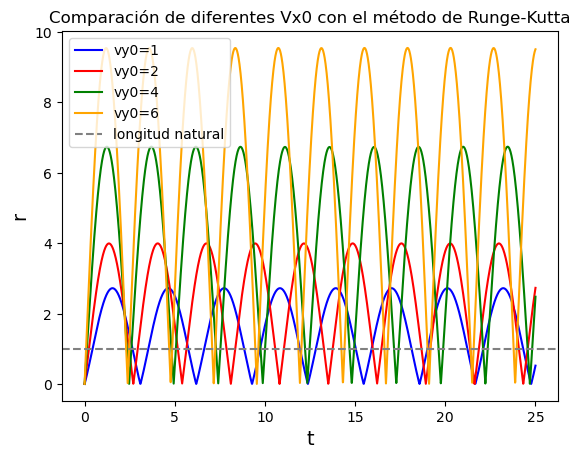

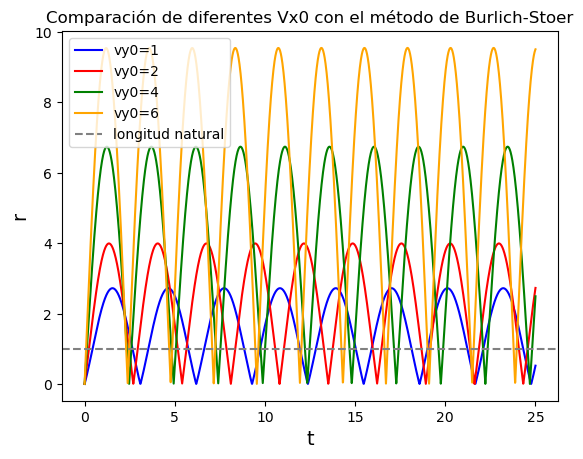

In [10]:
#Las graficamos en función del tiempo

plt.plot(t,r1, color='blue',label = "vy0=1")
plt.plot(t,r2, color='red',label = "vy0=2")
plt.plot(t,r3, color='green',label = "vy0=4")
plt.plot(t,r4, color='orange',label = "vy0=6")
plt.axhline(y = l0, color = 'grey', linestyle = 'dashed', label="longitud natural")
plt.xlabel('t',fontsize=14)
plt.ylabel('r', fontsize=14)
plt.legend(loc = 'best')
plt.title("Comparación de diferentes Vx0 con el método de Runge-Kutta")
plt.show()

plt.plot(t,r1bs, color='blue',label = "vy0=1")
plt.plot(t,r2bs, color='red',label = "vy0=2")
plt.plot(t,r3bs, color='green',label = "vy0=4")
plt.plot(t,r4bs, color='orange',label = "vy0=6")
plt.axhline(y = l0, color = 'grey', linestyle = 'dashed', label="longitud natural")
plt.xlabel('t',fontsize=14)
plt.ylabel('r', fontsize=14)
plt.legend(loc = 'best')
plt.title("Comparación de diferentes Vx0 con el método de Burlich-Stoer")
plt.show()

Análisis: De esta gráfica podemos concluir que variando la velocidad inicial en y y dejando las demás condicones y parametros iguales, a mayor velocidad inicial existe mayor asimetría en la oscilación de r con respecto a la longitud natural del resorte.

Existe muy poca diferencia entre el método de Runge-Kutta y el Burlich-Stoer extendido

In [11]:
#obtenemos los momentos angulares y los potenciales efectivos

L1=momento_angular(u1)
L2=momento_angular(u2)
L3=momento_angular(u3)
L4=momento_angular(u4)

L1bs=momento_angular(u1bs)
L2bs=momento_angular(u2bs)
L3bs=momento_angular(u3bs)
L4bs=momento_angular(u4bs)

V1=Pot_ef(u1,w,l0,L1)
V2=Pot_ef(u2,w,l0,L2)
V3=Pot_ef(u3,w,l0,L3)
V4=Pot_ef(u4,w,l0,L4)

V1bs=Pot_ef(u1bs,w,l0,L1bs)
V2bs=Pot_ef(u2bs,w,l0,L2bs)
V3bs=Pot_ef(u3bs,w,l0,L3bs)
V4bs=Pot_ef(u4bs,w,l0,L4bs)

E1=Emec(u1,w,l0)
E2=Emec(u2,w,l0)
E3=Emec(u3,w,l0)
E4=Emec(u4,w,l0)

E1bs=Emec(u1bs,w,l0)
E2bs=Emec(u2bs,w,l0)
E3bs=Emec(u3bs,w,l0)
E4bs=Emec(u4bs,w,l0)

In [12]:
#Cuantización de la simetría
def simetria(pot,r): 
    index=np.argmin(r[1:]) 
    pot1=pot[0:index]
    pot2=pot[index:]
    sim=abs(np.size(pot1)-np.size(pot2))
    return sim

In [13]:
sime=simetria(V1,r1)
sime3=simetria(V3,r3)
print(sime,sime3)

1265 2009


# b) Grafique el potencial efectivo respecto a la distancia relativa y justifique la asimetría.
# e) Incluimos las  energías mecánicas por unidad de masa en el gráfico para hacer el análisis

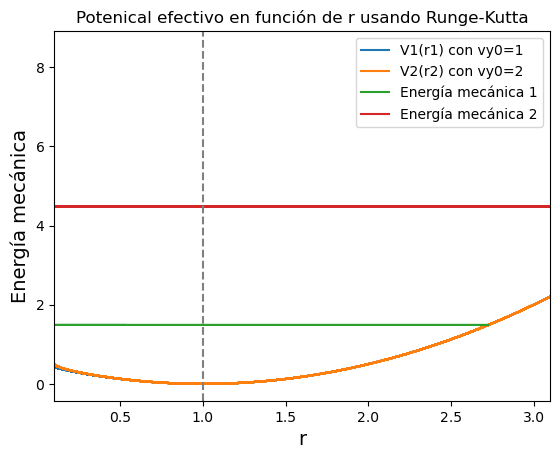

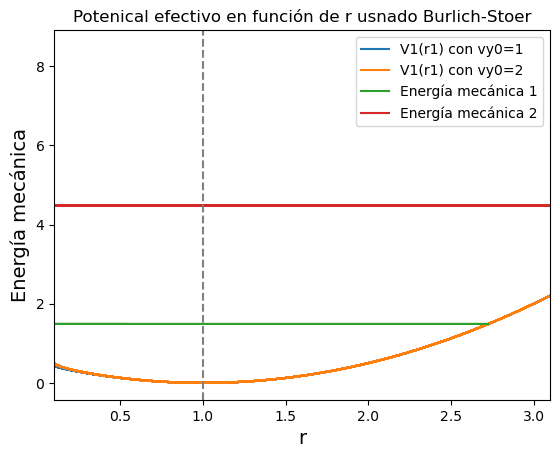

In [14]:
#Gráfica de la energía mecánica inicial y el potencial en función de r

plt.plot(r1,V1,label = "V1(r1) con vy0=1")
plt.plot(r2,V2,label = "V2(r2) con vy0=2")
plt.plot(r1,E1, label= "Energía mecánica 1")
plt.plot(r2,E2, label= "Energía mecánica 2")
plt.xlim(0.1,3.1)
plt.xlabel('r',fontsize=14)
plt.ylabel('Energía mecánica', fontsize=14)
plt.legend(loc = 'best')
plt.axvline(x=l0,color='grey',linestyle='dashed',label='longitud natural')
plt.title("Potenical efectivo en función de r usando Runge-Kutta")
plt.show()

plt.plot(r1bs,V1bs,label ="V1(r1) con vy0=1")
plt.plot(r2bs,V2bs,label = "V1(r1) con vy0=2")
plt.plot(r1bs,E1bs,label= "Energía mecánica 1")
plt.plot(r2bs,E2bs,label= "Energía mecánica 2")
plt.xlim(0.1,3.1)
plt.xlabel('r',fontsize=14)
plt.ylabel('Energía mecánica', fontsize=14)
plt.legend(loc = 'best')
plt.axvline(x=l0,color='grey',linestyle='dashed',label='longitud natural')
plt.title("Potenical efectivo en función de r usnado Burlich-Stoer")
plt.show()

# a) Modificar la energía mecánica sin modificar el potencial efectivo

Para hacer esto, modificamos las velocidad radial del sistema (velocidad en y) sin modificar la velocidad tangencial (velocidad en x) ya que el potencial efectivo sólo depende de la tangencial mientras que la energía mecánica depende también de la radial.

# b) Relación entre la simetría del movimiento y la energía mecánica

De la gráfica podemos cocnluir que para energías mecánicas bajas, el potencial efectivo es casi armónico, por lo que se espera una mayor simetría. A medida que la energía mecánica crece, el potencial efectivo bajo esa energía (el potecnial permitido) se va haciendo más y más asimétrico, por lo que el movimiento también. 

# c) Viendo el potencial efectivo, por qué el movimiento puede hacerse bastante asimétrico?

Porque debido a su forma, el potencial efectivo no es simétrico con respecto al mínimo que se encuentra en 1. En el máximo der la asimetría es máxima.

# d) Determinar la asimetría del movimiento.

Para determinar la asimetría del movimiento decidimos hacer una función que calculara la diferencia en el número de puntos del lado izquierdo al punto mínimo del potencial efectivo y el número de puntos del lado derecho al punto mínimo. Si fuera completamente simétrico, esta diferencia sería cero, por lo que el vaqlor de esta diferencia debe ser proporcional a la asimetría.

In [15]:
#Cuantización de la simetría
def simetria(pot,r): 
    index=np.argmin(r[1:]) 
    pot1=pot[0:index]
    pot2=pot[index:]
    sim=abs(np.size(pot1)-np.size(pot2))
    return sim

Nuestra hipótesis es que como V3 tiene una mayor energía mecánica que V1, su asimetría debe ser mayor 

In [16]:
sime=simetria(V1,r1)
sime3=simetria(V3,r3)
print("la diferencia en V1 es:",sime,"la diferencia den V2 es:",sime3)

la diferencia en V1 es: 1265 la diferencia den V2 es: 2009


# f) Resuélvalo también con su función BulirschStoerMultiple, compare los resultados.

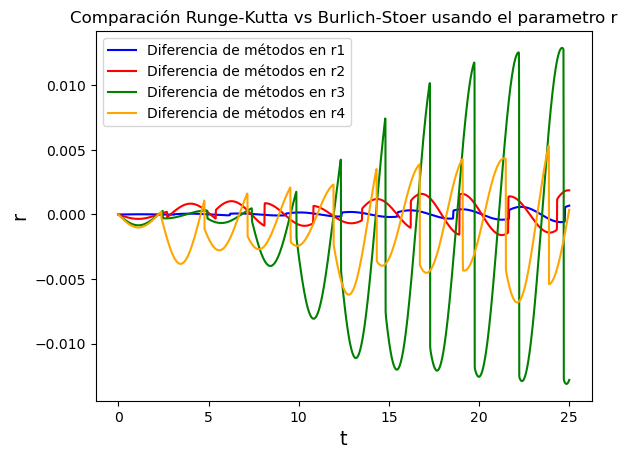

In [17]:
plt.plot(t,r1-r1bs, color='blue',label = "Diferencia de métodos en r1")
plt.plot(t,r2-r2bs, color='red',label = "Diferencia de métodos en r2")
plt.plot(t,r3-r3bs, color='green',label = "Diferencia de métodos en r3")
plt.plot(t,r4-r4bs, color='orange',label = "Diferencia de métodos en r4")
plt.xlabel('t',fontsize=14)
plt.ylabel('r', fontsize=14)
plt.legend(loc = 'best')
plt.title("Comparación Runge-Kutta vs Burlich-Stoer usando el parametro r")
plt.show()

En esta gráfica se restó los valores obtenidos para r con los dos métodos de resolución de ecuación diferenciales usados, de esta manera es fácil hacer la comparación. 
Los métodos concuerdan al principio de la simulación pero conforme aumenta el tiempo sus diferencias se hacen más grandes, con la mayor diferencia teniendo un valor 0.08 en el tiempo evaluado, también es importante notar que con un valor menor de velocidad inicial la diferencia entre los métodos es mayor. 